In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

# !pip install seaborn
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

/Users/yingqi/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Load data and pre-processing #
In our dataset, three variables **('isbuyer','multiple_buy','multiple_visit')** are dummy variables which need to be processed. 

In [3]:
data_train = pd.read_csv("ads_train.csv")
data_test = pd.read_csv("ads_test.csv")
data_train = data_train.iloc[:,1:]
data_test = data_test.iloc[:,1:]

print(data_train.shape)
print(list(data_train.columns))

(38209, 14)
['isbuyer', 'buy_freq', 'visit_freq', 'buy_interval', 'sv_interval', 'expected_time_buy', 'expected_time_visit', 'last_buy', 'last_visit', 'multiple_buy', 'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy']


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 14 columns):
isbuyer                38209 non-null int64
buy_freq               1620 non-null float64
visit_freq             38209 non-null int64
buy_interval           38209 non-null float64
sv_interval            38209 non-null float64
expected_time_buy      38209 non-null float64
expected_time_visit    38209 non-null float64
last_buy               38209 non-null int64
last_visit             38209 non-null int64
multiple_buy           38209 non-null int64
multiple_visit         38209 non-null int64
uniq_urls              38209 non-null int64
num_checkins           38209 non-null int64
y_buy                  38209 non-null int64
dtypes: float64(5), int64(9)
memory usage: 4.1 MB


In [5]:
X_train = data_train.iloc[:,:-1].fillna(0)
y_train = data_train.iloc[:,-1].fillna(0)
print(X_train.shape, y_train.shape)

(38209, 13) (38209,)


In [6]:
# create dummy variables
cat_vars=['isbuyer','multiple_buy','multiple_visit']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(X_train[var], prefix=var)
    data1=X_train.join(cat_list)
    X_train=data1

cat_vars=['isbuyer','multiple_buy','multiple_visit']
data_vars=X_train.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
X_train=X_train[to_keep]

X_test = data_test.fillna(0)
cat_vars=['isbuyer','multiple_buy','multiple_visit']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(X_test[var], prefix=var)
    data1=X_test.join(cat_list)
    X_test=data1

cat_vars=['isbuyer','multiple_buy','multiple_visit']
data_vars=X_test.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
X_test=X_test[to_keep]

X_train.columns.values

array(['buy_freq', 'visit_freq', 'buy_interval', 'sv_interval',
       'expected_time_buy', 'expected_time_visit', 'last_buy',
       'last_visit', 'uniq_urls', 'num_checkins', 'isbuyer_0',
       'isbuyer_1', 'multiple_buy_0', 'multiple_buy_1',
       'multiple_visit_0', 'multiple_visit_1'], dtype=object)

# Exploratory analysis #
In the training dataset, the ratio of no purchase performance over purchase is 99.5:0.5. We have imblalanced dataset so I will use SMOTE algorithm to create balanced dataset. Looking into the means of the 13 variables grouped buy different 'y_buy' values, we can find trends:

1. 96% percentage of those who didn't make a purchase is not a buyer before. 36.6% percentage of those who made a purchase is a buyer before.

2. The cookies which made a purchase has higher average in **buy_frequency, visit frequency, multiple_buy, multiple_visit**, where **multiple_buy** and **multiple_visit** are dummy variables denoting whether it made multiple purchases/visits before. 

3. The cookies which made a purchase has lower average in **last_buy_time, last_visit_time**. This is reasonable because customers who buy and visit websites more frequently are more likely to make another purchase. 

4. Surprisingly, the cookies with a purchase also experience an unexpected **uniq_urls, num_checkins**. 

5. We can notice that the two variables **'expected_time_buy'** and **'expected_time_visit'** have negative values and vary a lot among samples. They may denote the difference between the expected time and actual time to buy or visit.

In [7]:
data_train['y_buy'].value_counts()

0    38037
1      172
Name: y_buy, dtype: int64

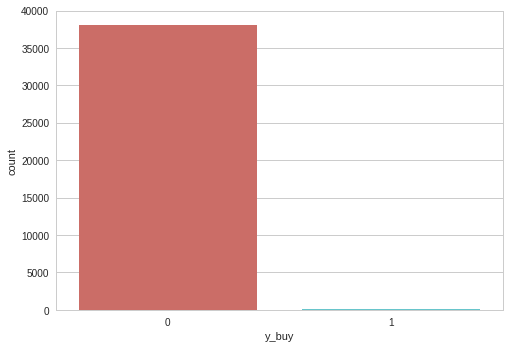

percentage of no purchase is 99.54984427752623
percentage of purchase 0.4501557224737628


<Figure size 576x396 with 0 Axes>

In [8]:
sns.countplot(x = 'y_buy', data = data_train, palette = 'hls')
plt.show()
plt.savefig('count_y_buy')

count_no_buy = len(data_train[data_train['y_buy']==0])
count_buy = len(data_train[data_train['y_buy']==1])
pct_of_no_buy = count_no_buy/(count_no_buy + count_buy)
print("percentage of no purchase is", pct_of_no_buy*100)
pct_of_buy = count_buy/(count_no_buy + count_buy)
print("percentage of purchase", pct_of_buy*100)

In [9]:
data_train.groupby('y_buy').mean()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins
y_buy,,,,,,,,,,,,,
0,0.040934,1.215800,1.843337,0.177045,5.852638,-0.159167,-10.158696,64.858112,64.858112,0.005337,0.275547,86.685464,724.641586
1,0.366279,1.825397,7.366279,4.701193,7.971977,-3.537766,-5.269058,20.267442,20.267442,0.145349,0.715116,66.505814,545.354651


# Train models #
The goal is to estimate if a cookie made a purchase during period of interest. The variable "y_buy" is binary, leading to a 2-class classification problem based on 13 dependent variables. Here I try different models and compare their performance.

Considering that our dataset is imbalanced and we don't have high-dimensional train features, the three methods I choose are: logistic regression, random forest and XGBoost. 

To assess the accuracy of our model, I split part of our training dataset as testing group. 

In [10]:
# Use SMOTE to split testing group for model evaluation

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, \
                                            test_size=0.25, random_state=10)
columns = Xtrain.columns

Xtrain,ytrain = os.fit_sample(Xtrain, ytrain)
Xtrain = pd.DataFrame(data=Xtrain,columns=columns)
ytrain = pd.DataFrame(data=ytrain,columns=['y_buy'])

# # we can Check the numbers of our data
print("length of oversampled data is ",len(Xtrain))
print("Number of no purchase in oversampled data",\
      len(ytrain[ytrain['y_buy']==0]))
print("Number of purchase",len(ytrain[ytrain['y_buy']==1]))
print("Proportion of no purchase data in oversampled data is ",\
      len(ytrain[ytrain['y_buy']==0])/len(ytrain))
print("Proportion of purchase data in oversampled data is ",\
      len(ytrain[ytrain['y_buy']==1])/len(ytrain))


length of oversampled data is  57056
Number of no purchase in oversampled data 28528
Number of purchase 28528
Proportion of no purchase data in oversampled data is  0.5
Proportion of purchase data in oversampled data is  0.5


## Logistic regression ##
Standardize all independent variables. Tune the parameter C for logistic regression. Parameter C controls the trade-off between model complexity and bias. For small values of C, we increase the regularization strength which will create simple models which avoids overfitting. For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.

After searching through all possible C parameters = [0.001, 0.01, 0.1, 1, 10, 100], we can find that C=0.01 generates better result.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_scaled = pd.DataFrame(data=scaler.transform(Xtrain),columns=columns)
Xtest_scaled = pd.DataFrame(data=scaler.transform(Xtest),columns=columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test),columns=columns)

# import statsmodels.api as sm
# logit_model=sm.Logit(ytrain,Xtrain_scaled)
# result=logit_model.fit()
# print(result.summary2())

In [12]:
from sklearn.linear_model import LogisticRegression

# Xtest2_scaled = Xtest_scaled.drop(['multiple_buy_0','multiple_buy_1',\
#                                    'num_checkins'],axis=1)
logreg = LogisticRegression(C = 0.01)
logreg.fit(Xtrain_scaled, ytrain)
y_pred = logreg.predict(Xtest_scaled)
score = logreg.score(Xtest_scaled, ytest)
print('Accuracy of logistic regression classifier on testing set: %.2f%%'% \
      (score*100))

Accuracy of logistic regression classifier on testing set: 85.14%


### Measure model performance ###

Evaluate performance of the model 'logreg' through confusion matrix and ROC curve.

1. Consion matrix

In testing group, 8100 entries with 'y_buy=0' are correctly classified as 0 and 1409 entries are misclassified as 1. 33 entries with 'y_buy=1' are correctly classified as 1 and 11 entries are misclassified as 0.

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ytest, y_pred)
print(confusion_matrix)

[[8100 1409]
 [  11   33]]


2. ROC curve and AUC

ROC curve calculates TFR (true positive rate) against FPR (false positive rate) at different threshold settings. AUC calculates the area under the curve.

$$Precision = \frac{\text{true positive}}{(\text{true positive} + \text{false positive})}$$

$$Recall = \frac{\text{true positive}}{(\text{true positive} + \text{false negative})}$$

In [14]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      9509
           1       0.02      0.75      0.04        44

   micro avg       0.85      0.85      0.85      9553
   macro avg       0.51      0.80      0.48      9553
weighted avg       0.99      0.85      0.92      9553



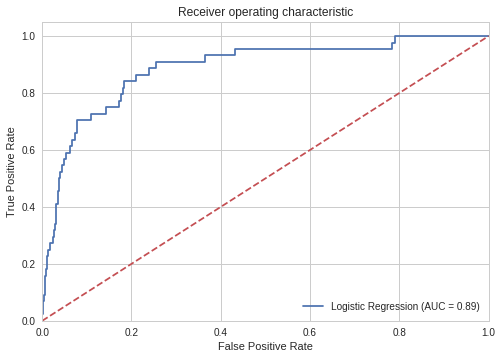

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytest, logreg.predict_proba(Xtest_scaled)[:,1])
fpr, tpr, thresholds = roc_curve(ytest, logreg.predict_proba(Xtest_scaled)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

No handles with labels found to put in legend.


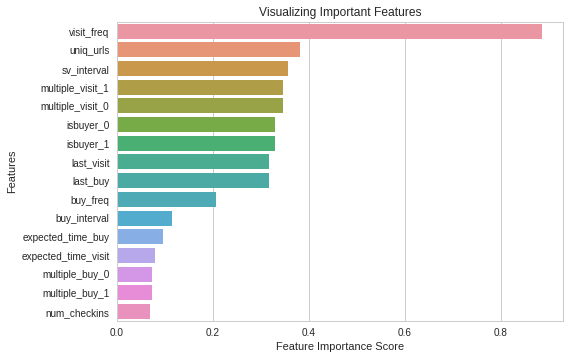

In [16]:
feature_imp = pd.Series(np.abs(logreg.coef_[0]),index=Xtrain.columns)\
                        .sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [17]:
coef = pd.Series(logreg.coef_[0],index=Xtrain.columns)\
                        .sort_values(ascending=False)
print(coef)

visit_freq             0.884770
multiple_visit_1       0.345961
isbuyer_1              0.329758
buy_freq               0.206529
buy_interval           0.116180
expected_time_visit    0.080903
multiple_buy_0         0.073263
num_checkins           0.070564
multiple_buy_1        -0.073263
expected_time_buy     -0.097053
last_visit            -0.317025
last_buy              -0.317025
isbuyer_0             -0.329758
multiple_visit_0      -0.345961
sv_interval           -0.356941
uniq_urls             -0.381789
dtype: float64


From the confusion matrix and precision-recall value we can tell that, logistic regression reaches 99% weighted precision and 85% weighted recall. It also performs well as shown in the ROC curve with AUC to be 0.89.

Variables **'visit_freq', 'multiple_visit_1'** have most significant positive effect on purchase. Variables **'sv_interval','uniq_urls'** have most significant negative effect on purchase. This is reasonable because a customer who visits more often is more likely to make his next purchase. A customer who makes visits with short interval and has fixed, relatively less websites which he visits often is also more likely to make his next purchase.

## Random Forest ##
Random forest limits the depth of tree which reduces overfitting problem in decision tree.

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, max_depth=5, \
                             class_weight='balanced')
rfc.fit(Xtrain,ytrain)
y_pred = rfc.predict(Xtest)
score = rfc.score(Xtest, ytest)
print('Accuracy of random forest tree classifier on testing set: %.2f%%'%\
      (score*100))

Accuracy of random forest tree classifier on testing set: 94.73%


No handles with labels found to put in legend.


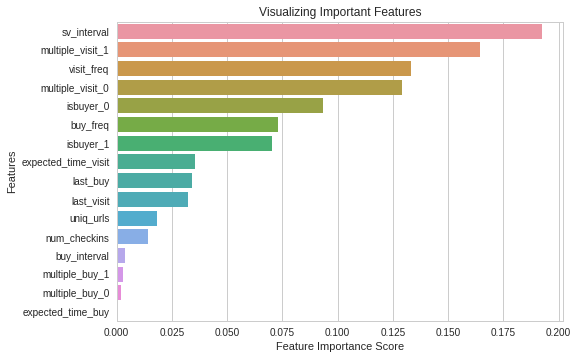

In [19]:
feature_imp = pd.Series(rfc.feature_importances_,index=Xtrain.columns)\
                        .sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Measure model performance ###

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(ytest, y_pred)
print(confusion_matrix)
print(classification_report(ytest, y_pred))

[[9023  486]
 [  17   27]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9509
           1       0.05      0.61      0.10        44

   micro avg       0.95      0.95      0.95      9553
   macro avg       0.53      0.78      0.53      9553
weighted avg       0.99      0.95      0.97      9553



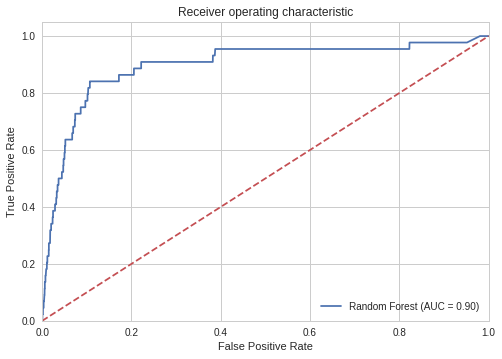

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rfc_roc_auc = roc_auc_score(ytest, rfc.predict_proba(Xtest)[:,1])
fpr, tpr, thresholds = roc_curve(ytest, rfc.predict_proba(Xtest)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RFC_ROC')
plt.show()

From the confusion matrix and precision-recall value we can tell that, this trained random forest classifier performs well both in classifying entries with 'y_buy=0' and 'y_buy=1', reaching 99% precision and 95% recall. Its ROC curve approaches left-top and has a large AUC value of 0.90.

Variables **'sv_interval', 'multiple_visit', 'visit_freq', 'is_buyer', buy_freq'** have most importance in classification, which is similar to the result of logistic regression. This is reasonable because a customer who buys and visits websites more often is more likely to make his next purchase. 

## XGBoost ##
XGBoost implements the gradient boosting decision tree algorithm. It has quick execution speed and better performance than normal gradient boosting algorithm.



In [22]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(learning_rate = 0.01,
                    n_estimators = 200,
                    max_depth = 5,
                    gamma = 1,
                    subsample = 0.8,
                    colsample_bytree = 0.8)
xgb.fit(Xtrain, ytrain)
y_pred=xgb.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print('Accuracy of XGBoost classifier on testing set: %.2f%%'% (accuracy*100))

Accuracy of XGBoost classifier on testing set: 95.60%


### Measure model performance ###

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(ytest, y_pred)
print(confusion_matrix)
print(classification_report(ytest, y_pred))

[[9112  397]
 [  23   21]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9509
           1       0.05      0.48      0.09        44

   micro avg       0.96      0.96      0.96      9553
   macro avg       0.52      0.72      0.53      9553
weighted avg       0.99      0.96      0.97      9553



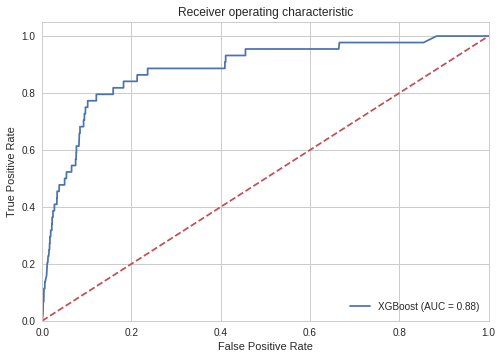

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
xgb_roc_auc = roc_auc_score(ytest, xgb.predict_proba(Xtest)[:,1])
fpr, tpr, thresholds = roc_curve(ytest, xgb.predict_proba(Xtest)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

No handles with labels found to put in legend.


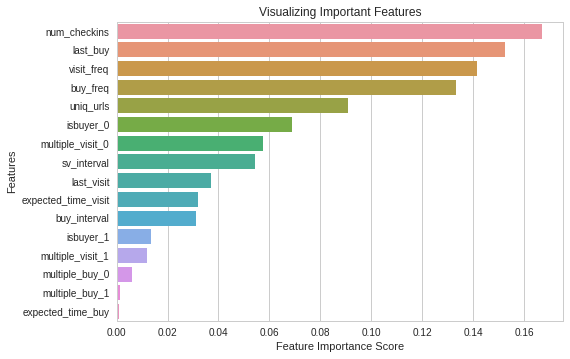

In [25]:
feature_imp = pd.Series(xgb.feature_importances_,index=Xtrain.columns)\
                        .sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()

From the confusion matrix and precision-recall value we can tell that, XGBoost reaches 99% weighted precision, 96% weighted recall and high training accuracy of 95.60%. It also has a good shaped ROC curve with AUC to be 0.88. It does well in classifying both 'y_buy=0' and 'y_buy=1' entries.

Variables **'num_checkins', 'last_buy', 'visit_freq', 'buy_freq', 'uniq_urls'** have most significant effect on purchase. This result coordinates with the result of logistic regression and random forest in some way. Overall, variables **'visit_freq', 'buy_freq'** are most optimal under three algorithms. This is reasonable because a customer who visits and buys more often is more likely to make his next purchase. 

# Predict labels on test dataset #
Here I use the above three ways to predict labels on test dataset. We can compare their performance below.

In [27]:
# 1. logistic regression
logpred = logreg.predict(X_test_scaled)
logprob = len(logpred[logpred==1])/len(logpred)
print("predicted probabilities of future purchase by logistic regression is:\
%.2f%%" % (logprob*100))
print("predicted labels of future purchase by logistic regression is: ",\
     logpred)

# 2. Random Forest
rfcpred = rfc.predict(X_test)
rfcprob = len(rfcpred[rfcpred==1])/len(rfcpred)
print("predicted probabilities of future purchase by Random Forest is: %.2f%%"\
      % (rfcprob*100))
print("predicted labels of future purchase by Random Forest is: ",rfcpred)


# 3. XGBoost
xgbpred = xgb.predict(X_test)
xgbprob = len(xgbpred[xgbpred==1])/len(xgbpred)
print("predicted probabilities of future purchase by XGBoost is: %.2f%%"\
      % (xgbprob*100))
print("predicted labels of future purchase by XGBoost is: ",xgbpred)


predicted probabilities of future purchase by logistic regression is:14.78%
predicted labels of future purchase by logistic regression is:  [0 0 0 ... 1 0 0]
predicted probabilities of future purchase by Random Forest is: 5.54%
predicted labels of future purchase by Random Forest is:  [0 0 0 ... 1 0 0]
predicted probabilities of future purchase by XGBoost is: 4.39%
predicted labels of future purchase by XGBoost is:  [0 0 0 ... 1 0 0]
